## ハードウェア固有のノイズの測定

In [768]:
import sys
sys.path.append("../../analysis")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy as sp
from scipy import signal
from scipy.optimize import curve_fit
from scipy import interpolate
from classes import NFPO
from numpy import sqrt
%matplotlib inline

warnings.simplefilter('ignore')

In [769]:
frequency = 920.4e6
light_speed = 2.998e8
wave_length = light_speed / frequency
antennas_population = 3
antennas_location = np.array([[-0.5,0],[0,0],[0.5,0]])
antenna_numbers = np.arange(1,antennas_population+1,1)
sample_count = 100
x_list = np.round(np.arange(-2.0,2.05,0.05), 2)
y_list = np.round(np.arange(1.0,3.0,1.0), 2)

In [770]:
def get_actual_phase(x,y,antenna_location):
    return (-4*np.pi*np.sqrt((x-antenna_location[0])**2 + (y-antenna_location[1])**2)/wave_length) % (2*np.pi)

In [771]:
def unwrap_with_gaps(phase_data, axis=0):
    """
    4次元配列の指定した軸（axis）に沿ってアンラッピングを実行する関数。
    欠損値（NaN）がある場合はスキップしてアンラッピングします。
    
    Parameters:
        array_4d (numpy.ndarray): 4次元配列
        axis (int): アンラッピングを行う軸（デフォルト: 2）
    
    Returns:
        numpy.ndarray: アンラッピング後の4次元配列
    """

    # 軸を移動してアンラッピングを適用しやすくする
    array_swapped = np.moveaxis(phase_data, axis, -1)  # 指定軸を最後に移動

    # アンラッピングを実行する
    result = np.empty_like(array_swapped)
    for index in np.ndindex(array_swapped.shape[:-1]):  # 最後の軸以外のすべてのインデックス

        # 現在のスライスを取り出し
        slice_data = array_swapped[index]

        # 欠損値（NaN）を考慮しつつアンラッピングを適用
        valid_indices = ~np.isnan(slice_data)
        unwrapped = np.full_like(slice_data, np.nan)  # 初期化（NaNで埋める）
        unwrapped[valid_indices] = np.unwrap(slice_data[valid_indices])  # 有効データをアンラップ
        
        # 結果を格納
        result[index] = unwrapped
    
    # 軸を元の位置に戻す
    result = np.moveaxis(result, -1, axis)
    return result

In [772]:
def get_phase_offsets(phases,x_list,y_list,antennas_location):

    if x_list.shape[0] != phases.shape[-1]:
        print("The tag populations between phase and x_list are not equal.")
        return
    
    unwrapped_phase = unwrap_with_gaps(phases, axis=3)

    actual_phases = np.empty(shape=np.delete(phases.shape, 2, 0))
    for index in np.ndindex(actual_phases.shape):
        antenna_location = antennas_location[index[1]]
        actual_phase = (-4*np.pi*np.sqrt((x_list[index[-1]]-antenna_location[0])**2 + (y_list[index[0]]-antenna_location[1])**2)/wave_length) % (2*np.pi)
        actual_phases[index] = actual_phase

    unwrapped_actual_phase = unwrap_with_gaps(actual_phases, axis=2)
    unwrapped_phase_mean = unwrapped_phase.mean(axis=2)

    offsets = (unwrapped_phase_mean - unwrapped_actual_phase) 

    A = np.empty(phases.shape[:-2])
    B = np.empty(phases.shape[:-2])
    C = np.empty(phases.shape[:-2])

    def fitting(x,a,b,c):
        return a*x**2 + b*x + c
    
    for index in np.ndindex(offsets.shape):
        offset = offsets[index[:-1]]
        param, _ = curve_fit(fitting, x_list, offset, nan_policy="omit" ,maxfev=1000000)

        fitted_offset = fitting(x_list,param[0],param[1],param[2])

        A[index[:-1]] = param[0]
        B[index[:-1]] = param[1]
        C[index[:-1]] = param[2]

        offsets[index[:-1]] = fitted_offset

    return offsets, A, B, C

def get_fixed_phase(phase, x_list, y_list, antennas_location):

    if x_list.shape[0] != phase.shape[-1]:
        print("The tag populations between phase and x_list are not equal.")
        return

    # phase_mean = phase.mean(axis=0)

    # def phase_equation(x,noise):
    #     return ((-4*np.pi*np.sqrt(x**2+y**2)/wave_length) + noise) % (2*np.pi)
    
    # param, _ = curve_fit(phase_equation, x_list, phase_mean)
    # noise = param[0]

    # fixed_phase = (phase - noise) % (2*np.pi)

    offsets = -get_phase_offsets(phase,x_list,y_list,antennas_location)

    fixed_phase = (phase + offsets) % (2*np.pi)
    
    return fixed_phase

def phase_fitting(phases, x_list, y_list, antennas_location):

    if x_list.shape[0] != phases.shape[3]:
        print("The tag populations between phase and x_list are not equal.")
        return
    
    phases_mean = unwrap_with_gaps(phases, axis=3).mean(axis=2) % (2*np.pi)
    
    result = np.empty(phases_mean.shape)
    for index in np.ndindex(result.shape[:-1]):
        y = y_list[index[0]]
        antenna_location = antennas_location[index[1]]

        def phase_equation(x,noise):
            return ((-4*np.pi*np.sqrt((x-antenna_location[0])**2+(y-antenna_location[1])**2)/wave_length) + noise) % (2*np.pi)
        
        param, _ = curve_fit(phase_equation, x_list, phases_mean[index], nan_policy="omit")

        result[index] = (phases_mean[index] - param[0]) % (2*np.pi)
        # phase_equation(x_list, param[0])

    return result

In [773]:
df = pd.read_csv("../data/main-experiment/data2.csv")
df["actual_phase"] = (-4*np.pi*np.sqrt((df["x"]-(df["antennaNumber"]-2)*0.5)**2+(df["y"])**2)/wave_length) % (2*np.pi)

nans = np.zeros([sample_count])
nans[:] = np.nan

phases=np.stack(
    [
        np.stack(
            [
                np.stack(
                    [
                        df[(df["x"]==x) & (df["y"]==y) & (df["antennaNumber"]==ant)]["phase"].to_numpy() if len(df[(df["x"]==x) & (df["y"]==y) & (df["antennaNumber"]==ant)]) == sample_count else nans for x in x_list
                    ],
                    axis=1
                )
                for ant in antenna_numbers
            ],
            axis=0,
        ) 
        for y in y_list
    ],
    axis=0
)

actual_phases=np.stack(
    [
        np.stack(
            [
                np.array(
                    [
                        get_actual_phase(x,y,antennas_location[ant-1]) for x in x_list
                    ]
                )
                for ant in antenna_numbers
            ],
            axis=0,
        ) for y in y_list
    ],
    axis=0,
)

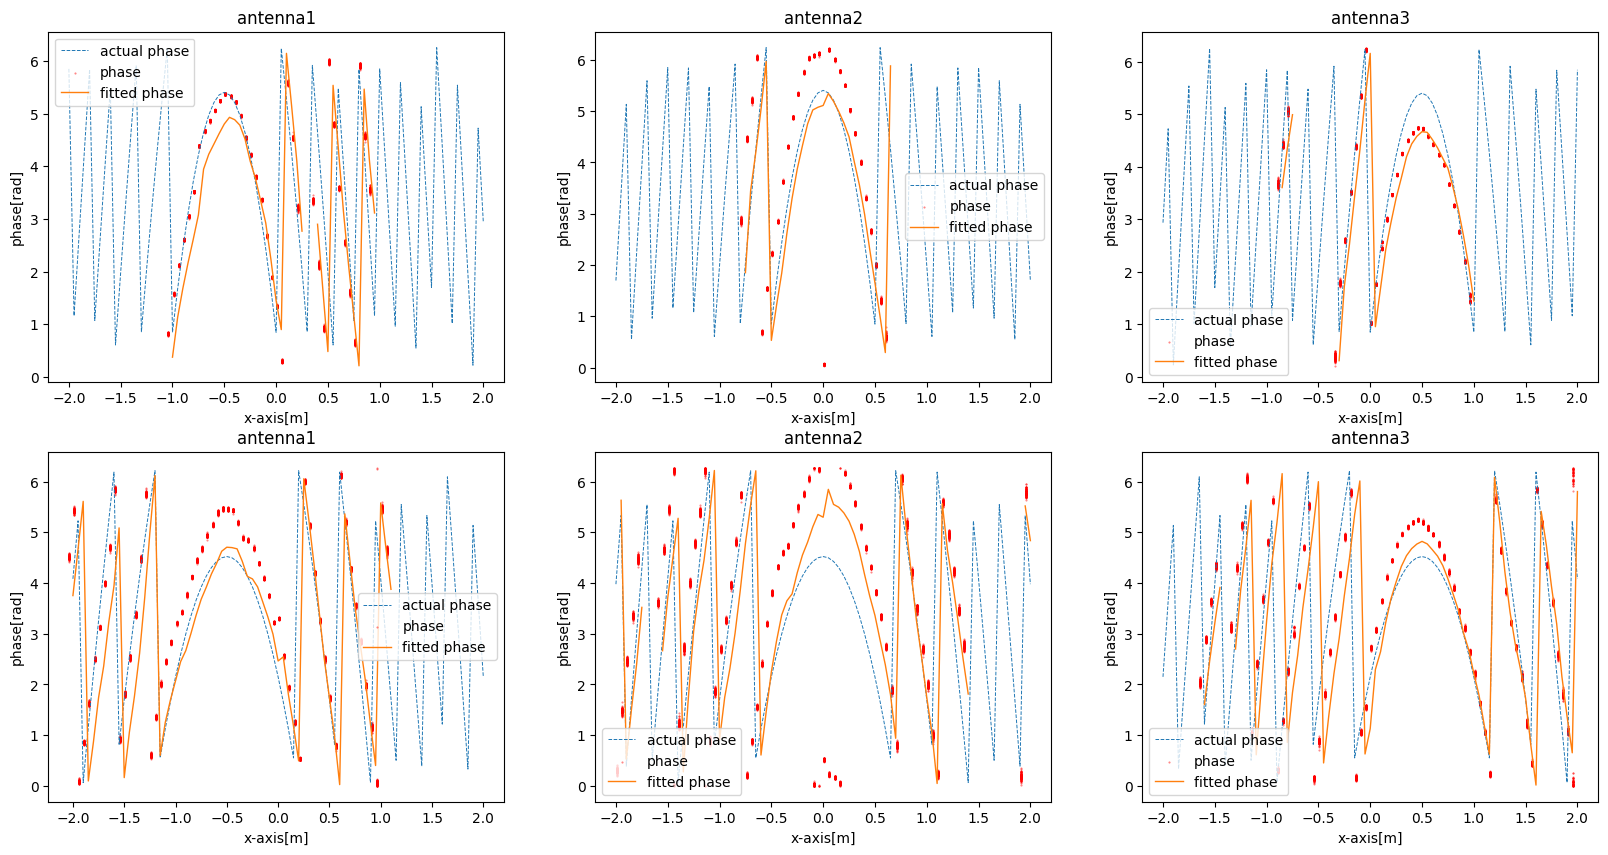

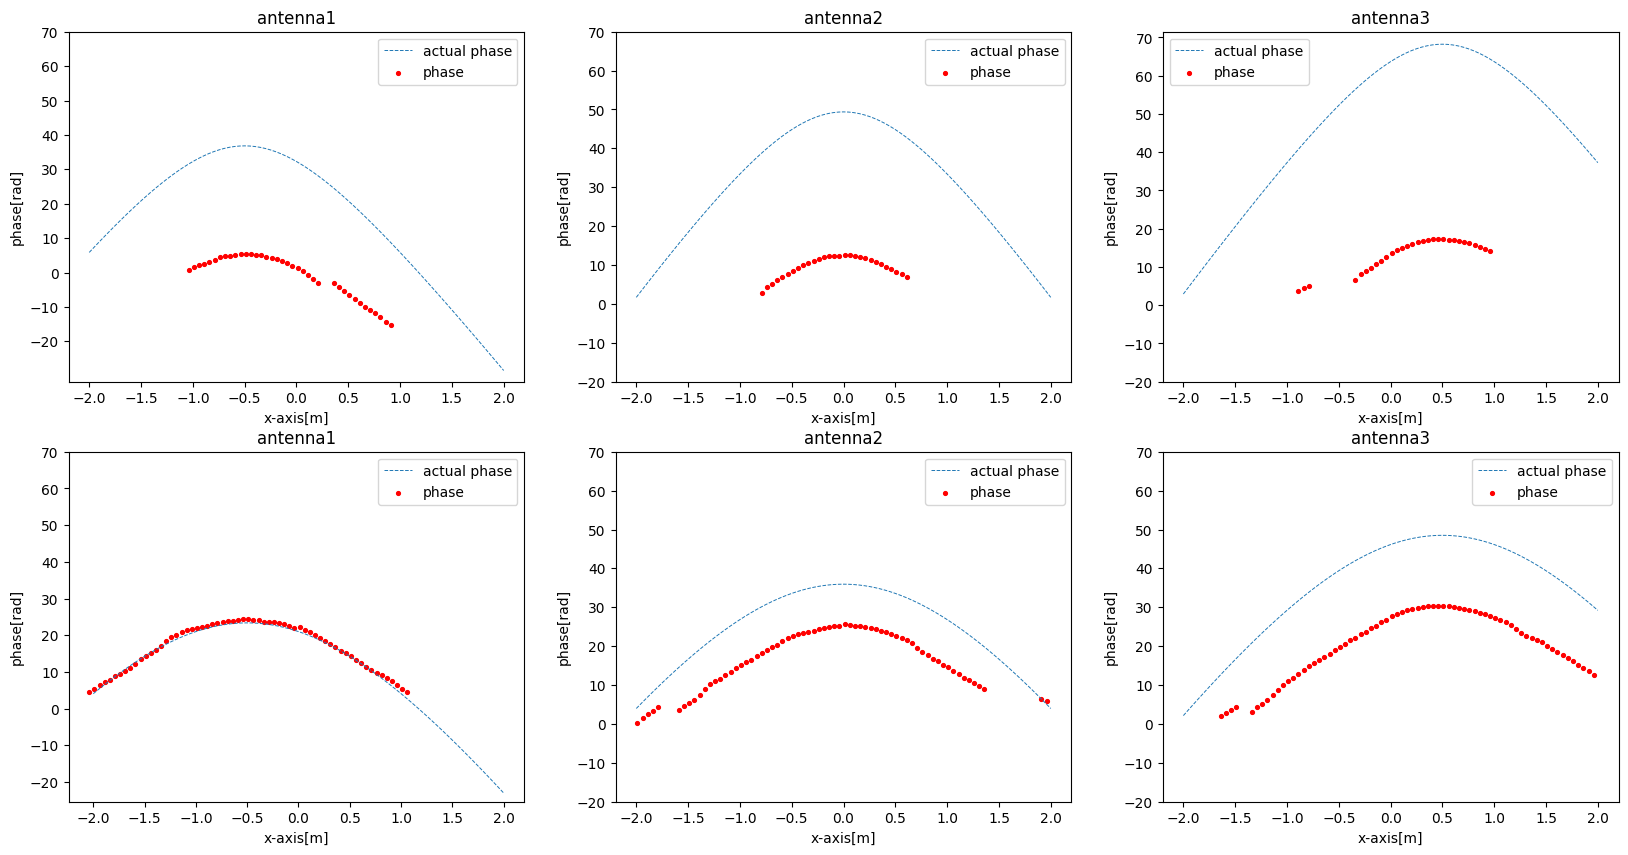

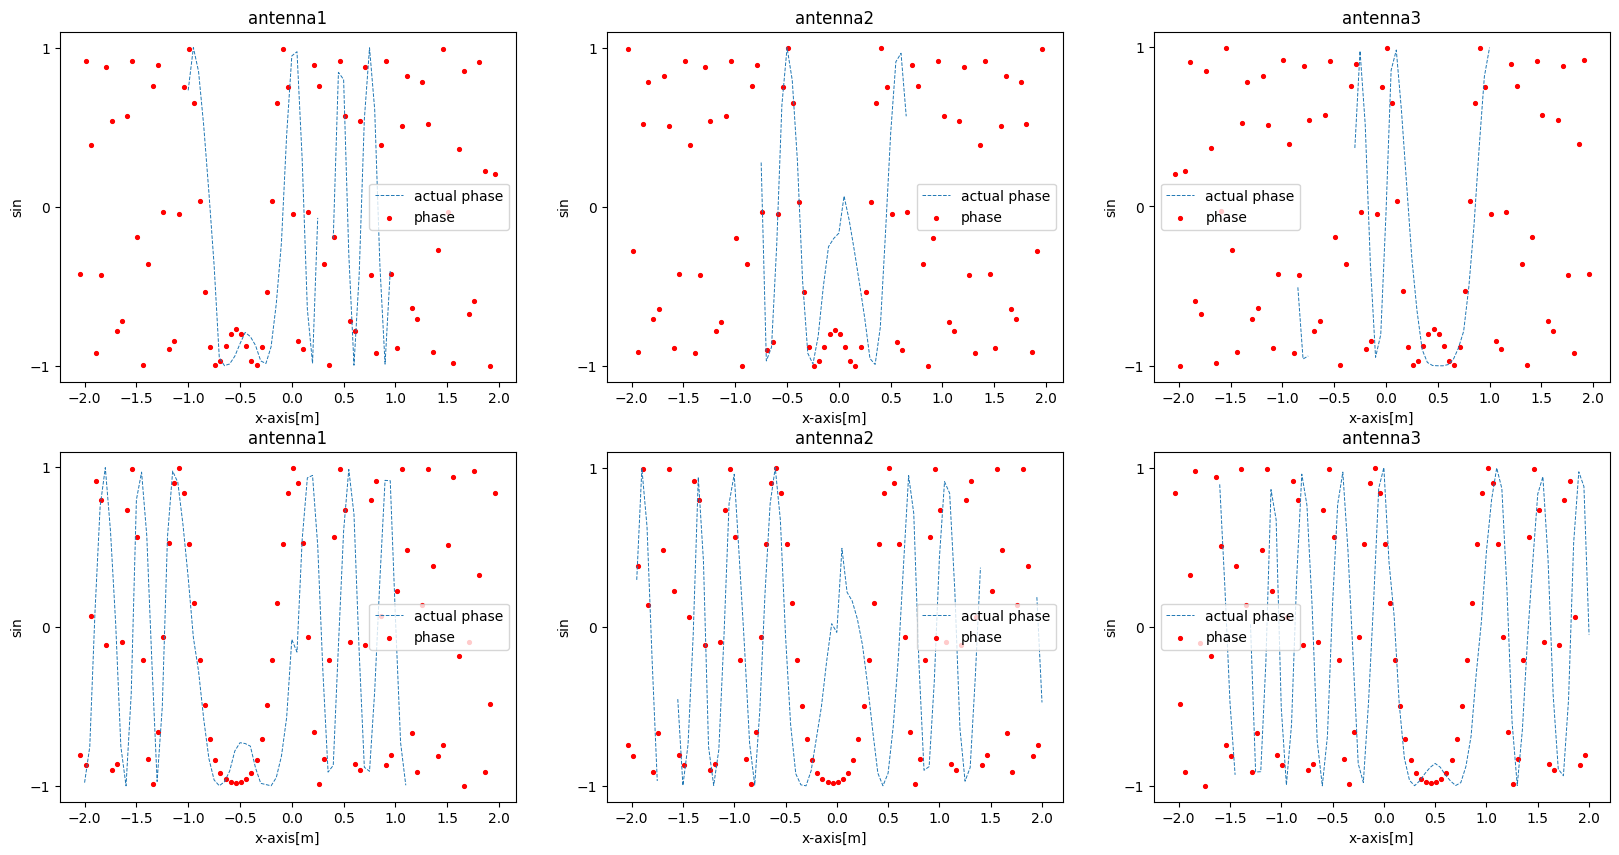

In [774]:
# phases = interpolate.interp1d(x_list, phases, axis=3, kind="cubic")(x_list)

unwrapped_phases = unwrap_with_gaps(phases, axis=3)
unwrapped_actual_phases = unwrap_with_gaps(actual_phases,axis=2)
unwrapped_phases_mean = unwrapped_phases.mean(axis=2)

# phases = unwrapped_phases % (2*np.pi)

phases_mean = unwrapped_phases_mean % (2*np.pi)

sins = np.sin(phases).mean(axis=2)
actual_sins = np.sin(actual_phases)

fitted_phsaes = phase_fitting(phases,x_list,y_list,antennas_location)

fig1, axes1 = plt.subplots(y_list.shape[0], antennas_population, figsize=(20,10))
fig2, axes2 = plt.subplots(y_list.shape[0], antennas_population, figsize=(20,10))
fig3, axes3 = plt.subplots(y_list.shape[0], antennas_population, figsize=(20,10))

validated_x_list = x_list - 0.0395

for i in range(y_list.shape[0]):
    for ant in antenna_numbers:
        axes1[i][ant-1].plot(x_list, actual_phases[i][ant-1], "--", label="actual phase", linewidth=0.7)
        axes1[i][ant-1].scatter(np.tile(x_list-0.0395, (sample_count,1)), phases[i][ant-1], marker=".", c="r", label="phase", s=1, alpha=0.5)
        axes1[i][ant-1].plot(x_list, fitted_phsaes[i][ant-1], "-", label="fitted phase", linewidth=1)
        axes1[i][ant-1].set_xlabel("x-axis[m]")
        axes1[i][ant-1].set_ylabel("phase[rad]")
        axes1[i][ant-1].set_title(f"antenna{ant}")
        axes1[i][ant-1].legend()
        axes2[i][ant-1].plot(x_list, unwrapped_actual_phases[i][ant-1], "--", label="actual phase", linewidth=0.7)
        axes2[i][ant-1].scatter(x_list-0.0395, unwrapped_phases_mean[i][ant-1], c="r", marker=".", label="phase", s=30)
        axes2[i][ant-1].set_xlabel("x-axis[m]")
        axes2[i][ant-1].set_ylabel("phase[rad]")
        axes2[i][ant-1].set_title(f"antenna{ant}")
        axes2[i][ant-1].set_yticks(np.arange(-20,80,10))
        axes2[i][ant-1].legend()
        axes3[i][ant-1].plot(x_list, sins[i][ant-1], "--", label="actual phase", linewidth=0.7)
        axes3[i][ant-1].scatter(x_list-0.0395, actual_sins[i][ant-1], c="r", marker=".", label="phase", s=30)
        axes3[i][ant-1].set_xlabel("x-axis[m]")
        axes3[i][ant-1].set_ylabel("sin")
        axes3[i][ant-1].set_title(f"antenna{ant}")
        axes3[i][ant-1].set_yticks(np.arange(-1,2,1))
        axes3[i][ant-1].legend()
plt.show()

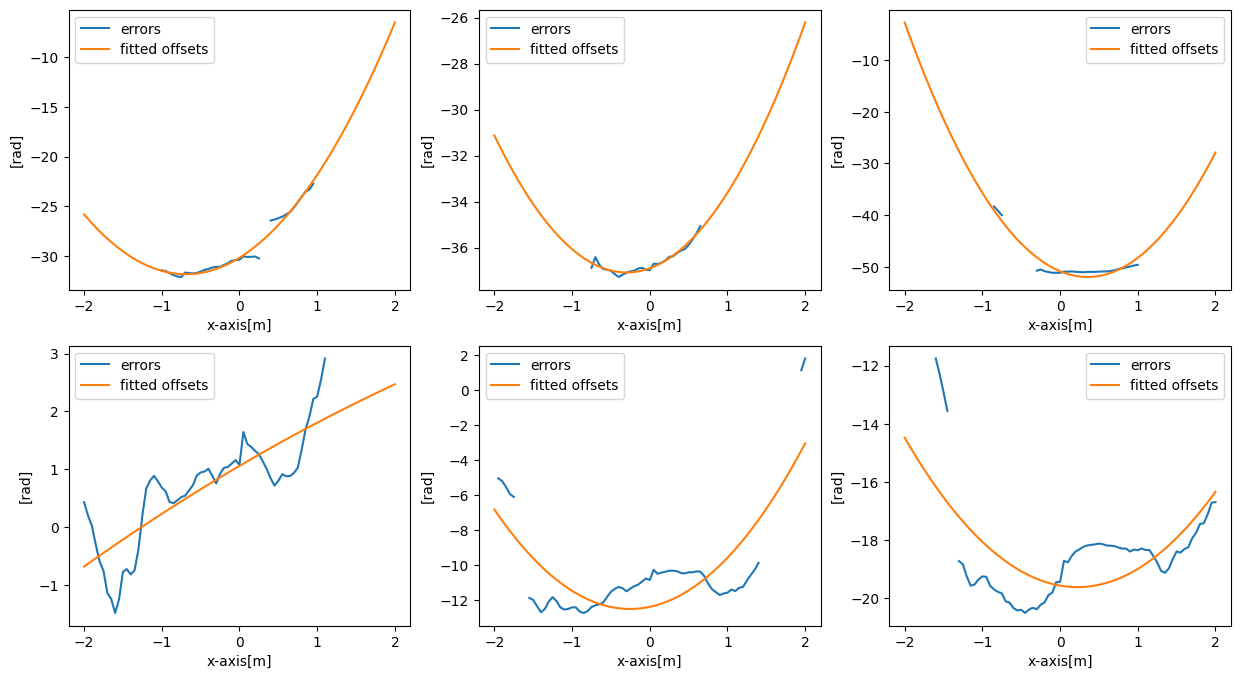

In [775]:
offsets = get_phase_offsets(phases=phases, x_list=x_list, y_list=y_list, antennas_location=antennas_location)[0]
# fixed_phase_mean = fixed_phase.mean(axis=2)
errors = (unwrapped_phases_mean - unwrapped_actual_phases) 

fig, axes = plt.subplots(y_list.shape[0],antennas_population,figsize=(15,8))
for i in range(y_list.shape[0]):
    for ant in antenna_numbers:
        axes[i][ant-1].plot(x_list, errors[i][ant-1], label="errors")
        axes[i][ant-1].plot(x_list, offsets[i][ant-1], label="fitted offsets")
        # axes[i][ant-1].set_yticks(np.arange(0,7.0,0.5))
        axes[i][ant-1].set_ylabel("[rad]")
        # axes[i][ant-1].set_xticks(np.arange(-1.0,1.1,0.1))
        axes[i][ant-1].set_xlabel("x-axis[m]")
        axes[i][ant-1].legend()

plt.show()

In [776]:
tag_population = 4
tags_space = 0.1
initial_value={"x":0,"y":1}
sample_count = 100

In [777]:
error_list = np.array([])
x_value = np.array([])
y_value = np.array([])

for i in np.arange(0, 151, 1):
    f = np.zeros(x_list.shape[0], dtype=bool)
    columns = i+10*np.arange(0,tag_population,1)
    f[columns] = True
    target_phases = fixed_phase[:,f]

    nfpo = NFPO(
        sample_count=sample_count,
        tags_space=tags_space,
        phases=target_phases,
        tag_population=tag_population,
        wave_length=wave_length,
        tag_location={"x":x_list[i],"y":1.0},
        initial_value=initial_value,
        x_err_range=1.0,
        y_err_range=1.0
    )

    result = nfpo.solve()
    error = sqrt((result["values"]["x"]-(i*0.01-1.0))**2+(result["values"]["y"]-1.0)**2)
    x_value  = np.append(x_value, result["values"]["x"])
    y_value  = np.append(y_value, result["values"]["y"])
    error_list=np.append(error_list,error)
value = np.array([x_value, y_value])

TypeError: 'NoneType' object is not subscriptable

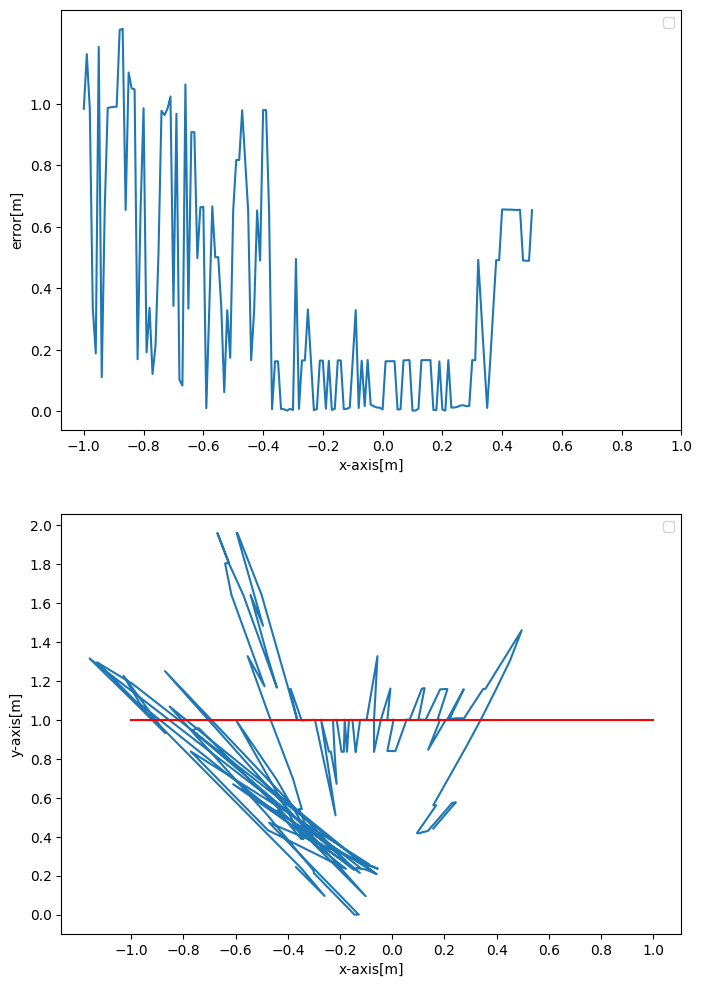

In [9]:
fig,axes = plt.subplots(2,1, figsize=(8,12))

axes[0].plot(x_list[0:151],error_list)
axes[0].set_ylabel("error[m]")
axes[0].set_yticks(np.arange(0,1.1,0.2))
axes[0].set_xlabel("x-axis[m]")
axes[0].set_xticks(np.arange(-1.0,1.1,0.2))
axes[0].legend()

axes[1].plot(x_value,y_value)
axes[1].plot(x_list,y_list, c="r")
axes[1].set_ylabel("y-axis[m]")
axes[1].set_xlabel("x-axis[m]")
axes[1].set_yticks(np.arange(0,2.2,0.2))
axes[1].set_xticks(np.arange(-1.0,1.1,0.2))
axes[1].legend()